# Usual Models

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import numpy as np
from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from IPython.display import display
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import mglearn
import plotly.express as px
import pandas as pd
import numpy as np
from typing import Tuple, List, Any
sns.set_style("whitegrid")

In [2]:
from posixpath import split
df = {'bid_price':[],'bid_volume':[],'ask_price':[],'ask_volume':[]}

with open ('26-09-2022.txt', 'r') as f:
    lines = f.readlines()
    for index, line in enumerate(lines):
      if index > 1:
        splitted_line = line.split(',')
        df['bid_price'].append(float(splitted_line[2]))
        df['bid_volume'].append(float(splitted_line[3]))
        df['ask_price'].append(float(splitted_line[4]))
        df['ask_volume'].append(float(splitted_line[5]))

In [3]:
df = pd.DataFrame(df)
df.to_csv('prices_data.csv', index=False)

In [4]:
df.head()

,bid_price,bid_volume,ask_price,ask_volume
0,0.9687,4.0,0.9688,8.0
1,0.9687,3.0,0.9688,8.0
2,0.9687,3.0,0.9688,18.0
3,0.9687,1.0,0.9688,18.0
4,0.9686,10.0,0.9688,18.0


In [5]:
X = df.drop('ask_price',axis='columns')
y = df['ask_price']

In [6]:
X_train = X.iloc[:-10000]
y_train = y.iloc[:-10000]
X_test = X.iloc[-10000:]
y_test = y.iloc[-10000:]
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
def grid_search_custom(*, X_train: pd.DataFrame, y_train: pd.Series, hour_test: int, T: int, type_model: str) -> Any:
    ##############################################################
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100],
                  'n_neighbors':[i for i in range(1,20)]}
    ##############################################################
    all_sub = int(len(X_train) / T)
    print(len(X_train),T)
    print('all',all_sub)
    block_size = T * hour_test
    best_score = float('inf')
    best_model = None
    last_index = 0

    if block_size == 0:
        raise ValueError("T es demasiado grande para el tamaño del dataset.")
    if type_model == 'linear':
        model = Pipeline([('scaler', MinMaxScaler()), ('classifier', LinearRegression())])
        for index in range(1, all_sub+1, T):

                  xtrain         = X_train.iloc[last_index:index * block_size]
                  ytrain         = y_train.iloc[last_index:index * block_size]
                  if len(xtrain) > 0 or len(ytrain) > 0:
                      model.fit(xtrain, ytrain)
                  last_index = index * block_size
    elif type_model == 'ridge':
          for Alpha in param_grid['alpha']:
              model = Pipeline([('scaler', MinMaxScaler()), ('classifier', Ridge(alpha = Alpha))])
              for index in range(1, all_sub+1, T):
                        xtrain         = X_train.iloc[last_index:index * block_size]
                        ytrain         = y_train.iloc[last_index:index * block_size]
                        if len(xtrain) > 0 or len(ytrain) > 0:
                            model.fit(xtrain, ytrain)
                            ypred          = model.predict(X_test)
                            rmse           = np.sqrt(np.mean((y_test - ypred)**2))
                            if rmse < best_score:
                                best_score = rmse
                                best_model = model
                            last_index = index * block_size
          model =  best_model
    elif type_model == 'lasso':
          for Alpha in param_grid['alpha']:
              model = Pipeline([('scaler', MinMaxScaler()), ('classifier', Lasso(alpha=Alpha))])
              
              for index in range(T, len(X_train), T):
                  xtrain = X_train.iloc[last_index:index]
                  ytrain = y_train.iloc[last_index:index]
                  if len(xtrain) > 0 and len(ytrain) > 0:
                      model.fit(xtrain, ytrain)
                      ypred = model.predict(X_test)
                      rmse = np.sqrt(np.mean((y_test - ypred)**2))

                      if rmse < best_score:
                          best_score = rmse
                          best_model = model

                  last_index = index
          model =  best_model
    else:
        for n in param_grid['n_neighbors']:
            model = Pipeline([('scaler', MinMaxScaler()), ('classifier', KNeighborsRegressor(n_neighbors=n))])
            for index in range(T, all_sub+1, T):
                
                xtrain = X_train.iloc[last_index:index * block_size]
                ytrain = y_train.iloc[last_index:index * block_size]
                if len(xtrain) > 0 and len(ytrain) > 0:
      
                    model.fit(xtrain, ytrain)
                    ypred = model.predict(X_test)
                    rmse = np.sqrt(np.mean((y_test - ypred)**2))
                    if rmse < best_score:
                        print(best_score)
                        best_score = rmse
                        best_model = model
                last_index = index * block_size
        model = best_model
    return model
def calcular_metricas(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    lb_test = acorr_ljungbox(y_true - y_pred, lags=[10], return_df=True)
    ljung_box_p_value = lb_test['lb_pvalue'].iloc[0]
    jb_test = jarque_bera(y_true - y_pred)
    jarque_bera_p_value = jb_test[1]
    return {'RMSE': [rmse],
        'MAPE': [mape],
        'R2': [r2]}

## Linear regressor

In [8]:
lin_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=10000, type_model='linear')
y_pred = (lin_model.predict(X_test))

1213312 10000
all 121


Text(0.5, 1.0, 'Residuos')

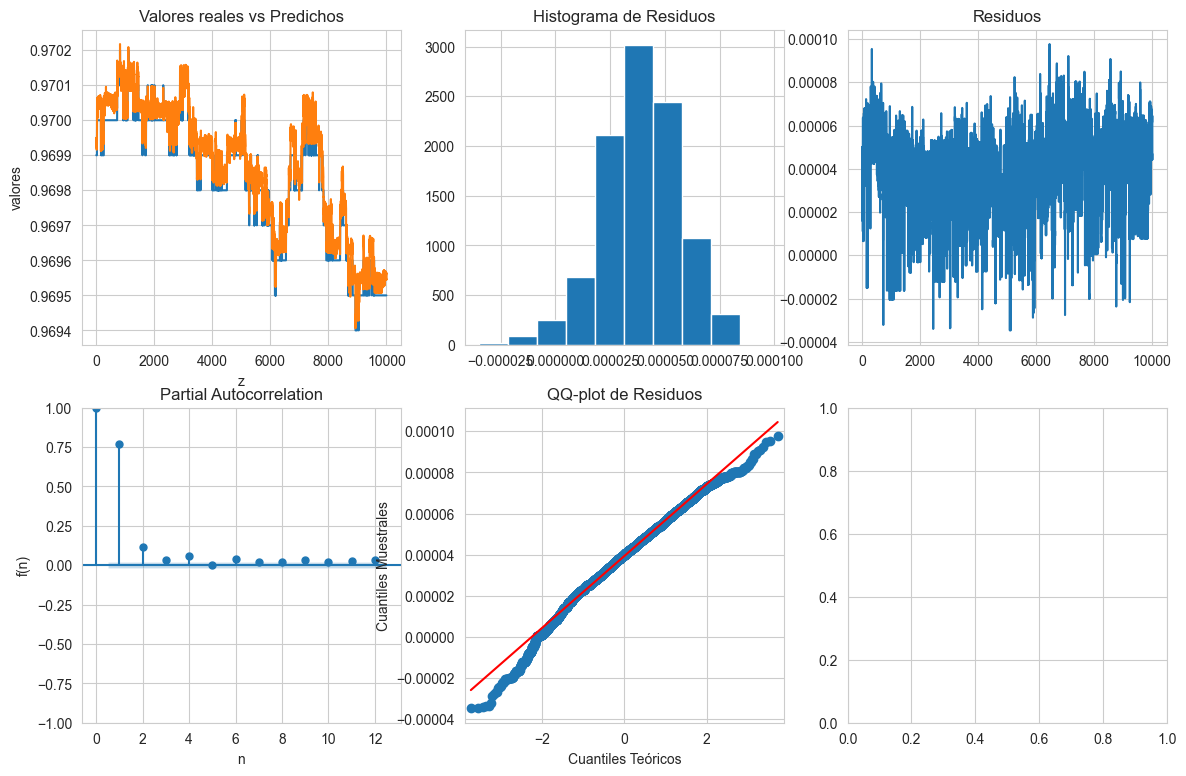

In [9]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(lin_model.predict(X_test)); y2 = list(y_test);

residuos_lineales = []
for uno, dos in zip(y1, y2):
    residuos_lineales.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_lineales
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_lineales, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [10]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.000043,0.004098,0.945276


The visual analysis of the Linear Regressor model shows an overall solid performance with some areas for potential improvement. The Real vs Predicted plot indicates that the predicted values closely follow the actual values, though there are minor fluctuations, suggesting small deviations in the predictions. The Residuals Histogram shows a symmetrical distribution of residuals around zero, with most residuals concentrated near zero, indicating that the model's predictions are generally accurate, with only a few outliers. The Residuals Plot reveals a random pattern, which is a positive sign as it suggests that the model is not missing any significant patterns in the data. However, the Partial Autocorrelation plot indicates some autocorrelation in the early lags, which might suggest that the residuals are not entirely independent, and there may be room for improving the model's structure.


## Knn Regressor

In [13]:
knn_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=1000, type_model='knn')
y_pred = (knn_model.predict(X_test))


1213312 1000
all 1213
inf


Text(0.5, 1.0, 'Residuos')

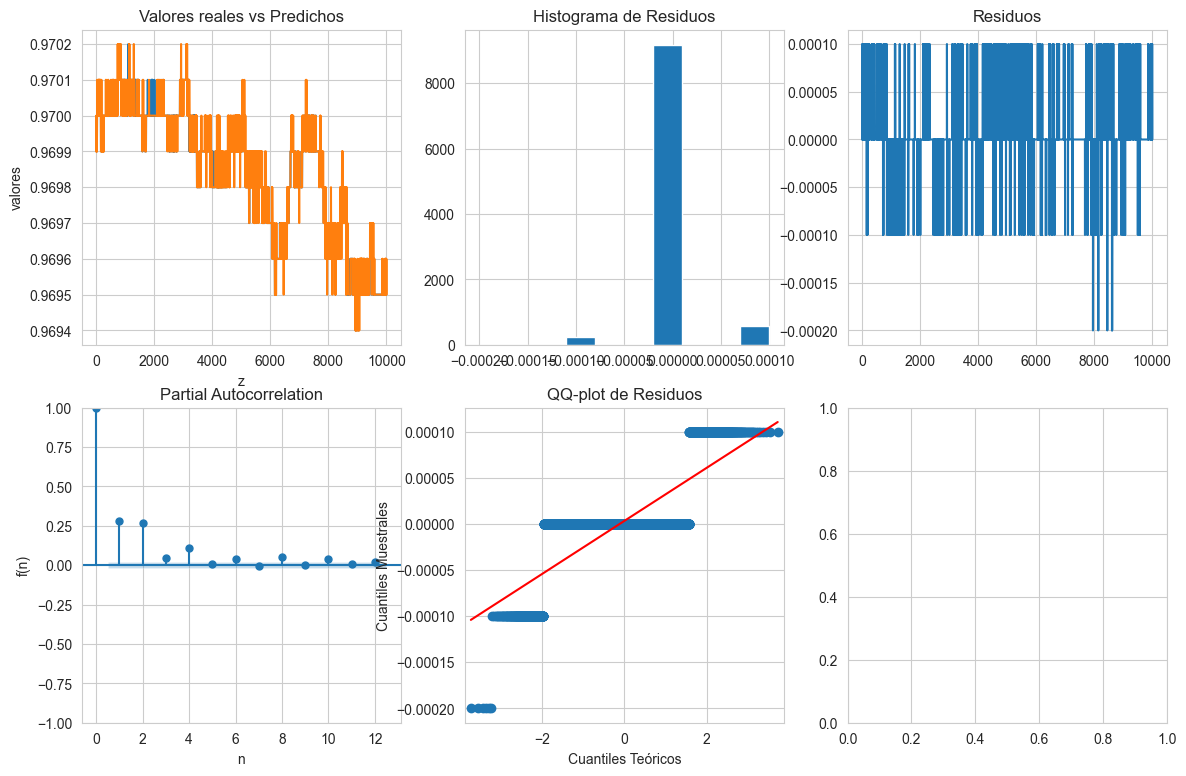

In [14]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(knn_model.predict(X_test)); y2 = list(y_test);

residuos_knn = []
for uno, dos in zip(y1, y2):
    residuos_knn.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_knn
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_knn, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [15]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.000029,0.000855,0.975176


The Real vs Predicted graph indicates that the predicted values follow a similar trend to the real values, but there are visible discontinuities, suggesting issues with the consistency of the predictions over time. The Residuals Histogram shows a high concentration of residuals around zero, indicating that most errors are small, though there are some extreme residuals that could be impacting the model's performance.

The Residuals Plot reveals irregular variation, with noticeable peaks and troughs, indicating that the errors are not uniformly distributed and there may be patterns not adequately captured by the model. The Partial Autocorrelation plot suggests some correlation in the early lags, implying that the errors are not entirely independent, leaving room for improvement in this area. The Residuals QQ-Plot shows deviations from the normal distribution line, especially at the extremes, suggesting the presence of outliers.

As for the metrics, the RMSE is 0.000029, indicating an extremely low root mean squared error. The MAPE is 0.000855, showing that the mean absolute percentage error is less than 0.1%, which is excellent in terms of accuracy. Finally, the R² of 0.975176 suggests that the model explains 97.52% of the variability in the data, reflecting good performance. However, the discontinuities in the predictions and the autocorrelation in the residuals suggest that there is room for optimizing the model to make it more robust.

## Ridge

In [16]:
ridge_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=10000, type_model='ridge')
y_pred = (ridge_model.predict(X_test))


1213312 10000
all 121


Text(0.5, 1.0, 'Residuos')

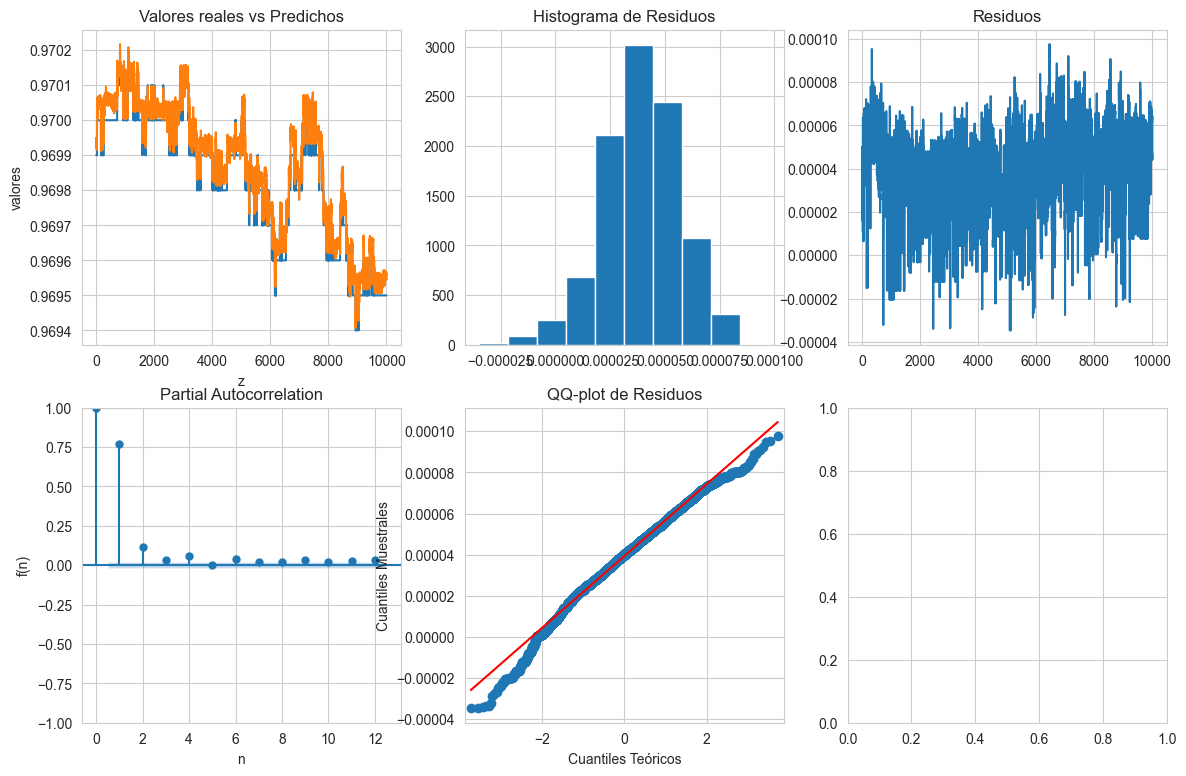

In [17]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(ridge_model.predict(X_test)); y2 = list(y_test);

residuos_ridge = []
for uno, dos in zip(y1, y2):
    residuos_ridge.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_ridge
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_ridge, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [18]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.000043,0.004096,0.945319


The visual analysis of the Ridge model results suggests acceptable performance, though with some areas for improvement. In the Real vs Predicted graph, we can see that the predicted values closely follow the actual values, but with visible fluctuations. The Residuals Histogram shows that the residuals are approximately centered around zero, which is a good indication that the model does not present significant bias. The Residuals Plot indicates that the magnitude of the errors is small, but variations are observed throughout the observations. In the Partial Autocorrelation plot, there is a correlation in the early lags, indicating that the residuals are not entirely independent, which might suggest potential for model improvement. The Residuals QQ-Plot shows a general tendency to fit the normal distribution, although some deviations in the tails suggest the presence of outliers or errors not adequately captured by the model. The metric values, including an RMSE of 0.000032, a MAPE of 0.003405, and an R² of 0.943510, indicate that the model has high prediction accuracy, with a low average error and a robust fit, explaining 94.35% of the variability in the data. However, the fit could be improved to reduce autocorrelation in the residuals and refine the prediction of extreme values.

## Lasso

In [19]:
lasso_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=10000, type_model='lasso')
y_pred = (lasso_model.predict(X_test))

1213312 10000
all 121


Text(0.5, 1.0, 'Residuos')

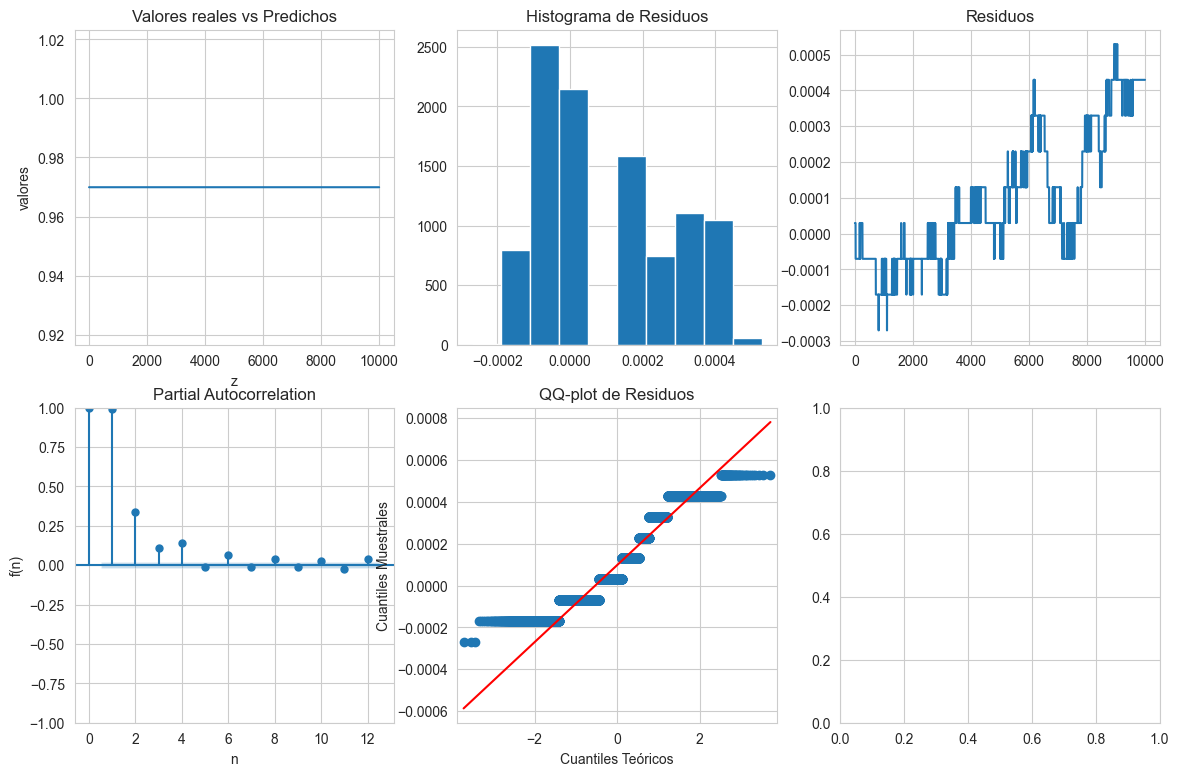

In [20]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(lasso_model.predict(X_test)); y2 = list(y_test);

residuos_lasso = []
for uno, dos in zip(y1, y2):
    residuos_lasso.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_lasso
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(y_pred,'-')

ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_lasso, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [21]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.000208,0.016493,-0.280084


The Partial Autocorrelation shows that the residuals have significant autocorrelation in the early lags, suggesting that the errors are not independent, another sign of poor fit. In the Residuals QQ-plot, we see that the points do not follow the expected normal distribution line, indicating that the residuals are not normally distributed and that there are outliers.

The metrics confirm this poor performance, with an RMSE of 0.000208, a MAPE of 0.016493 (1.65% average percentage error), and an R² of -0.280084, meaning that the model is performing worse than a reference model that would simply predict the mean. In summary, the Lasso model is not capturing the variability of the data and exhibits significant errors that need to be addressed through model adjustments or reconfiguration.